In [1]:
"""
# 전처리 배분

1(성준) - 0~9,   40~49, 80~89, 120, 
       - credit_card_balance.csv
       - POS_CASH_balance.csv
       - previous_application.csv
       - installments_payments.csv
2(장호) - 10~19, 50~59, 90~99, 121
3(두영) - 20~29, 60~69, 100~109, 122, 
       - bureau.csv,
4(혜빈) - 30~39, 70~79, 110~119, 123, 
       - bureau_balance.csv
5(준혁) -  
"""

"""
# 데이터 목록
application_test.csv
application_train.csv
credit_card_balance.csv
POS_CASH_balance.csv
previous_application.csv
installments_payments.csv
bureau.csv
bureau_balance.csv
sample_submission.csv
"""

'\n# 데이터 목록\napplication_test.csv\napplication_train.csv\nPOS_CASH_balance.csv\nbureau.csv\nbureau_balance.csv\ncredit_card_balance.csv\ninstallments_payments.csv\nprevious_application.csv\nsample_submission.csv\n'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import user_functions as uf

# 한글 출력되게 설정
uf.korean()

In [8]:
def korean():
    import platform
    # 운영체제별 한글 폰트 설정
    if platform.system() == 'Darwin': # Mac 환경 폰트 설정
        plt.rc('font', family='AppleGothic')
    elif platform.system() == 'Windows': # Windows 환경 폰트 설정
        plt.rc('font', family='Malgun Gothic')

    plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

    # 글씨 선명하게 출력하는 설정
    %config InlineBackend.figure_format = 'retina'

korean()

In [3]:
# Load file
train_datasets = pd.read_csv(uf.get_f_path()+"application_train.csv")
test_datasets = pd.read_csv(uf.get_f_path()+"application_test.csv")

# Label 만들기
train_target_ds = train_datasets["TARGET"]

# TARGET feature 삭제
train_datasets.drop(columns="TARGET", inplace=True)

NameError: name 'uf' is not defined

In [4]:
# info
print(train_datasets.info())
print(test_datasets.info())

# train은 307,511 행
# test는   48,744 행
# -----------------
# 총      356,255 행

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 283.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


In [18]:
test_datasets.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'train/test'],
      dtype='object', length=122)

In [5]:
# train datasets과 test datasets을 구분하는 "train/test" feature 생성
train_datasets["train/test"] = "train"
test_datasets["train/test"] = "test"

# 합치기
train_test_datasets = pd.concat([train_datasets, test_datasets], ignore_index=True)

# 356,255 행인지 확인
train_test_datasets.info()

# index 재설정
# print(train_datasets.index)
# print(test_datasets.index)
train_test_datasets.reset_index(drop=True, inplace=True)
# print(train_test_datasets.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 122 entries, SK_ID_CURR to train/test
dtypes: float64(65), int64(40), object(17)
memory usage: 331.6+ MB


In [6]:
# 전처리 데이터
prepro_ds = train_test_datasets.copy()

# 데이터 전처리 진행 및 특이사항
---

## "TARGET"
- 연체자가 적은 편향된 데이터
- value_counts()
- 1=연체
> ```python
> 0    282686
> 1     24825
> ```

<hr><br>

## "CODE_GENDER"
- 'M', 'F', 'XNA'
- 'XNA'는 결측치라기 보다는 간성 등으로 파악됨. 따라서 그대로 놔둠
- []숫자로 대치
- 성별
- value_counts()
> ```python
> F      202448
> M      105059
> XNA         4
> ```

<hr><br>

## "FLAG_OWN_CAR", "FLAG_OWN_REALTY"
- 'Y', 'N'
- []숫자로 대치

<hr><br>

## "CNT_CHILDREN"
- [V] 5명 이상인 값을 5 이상으로 처리
- []숫자로 대치
- value_counts()
> ```python
> 0     215371
> 1      61119
> 2      26749
> 3       3717
> 4        429
> 5         84
> 6         21
> 7          7
> 14         3
> 8          2
> 9          2
> 12         2
> 10         2
> 19         2
> 11         1
> ```

<hr><br>

## "AMT_INCOME_TOTAL"
- 117000000 값은 이상치로 판단됨. 대출액 대비 소득 수준을 볼 때 fatfinger로 판단됨
- [V] 117000000 / 10으로 대체함
- <span style="color:yellow">TODO: 편차가 크다고 판단되나, 우선 그대로 진행함</span>


<hr><br>

## "AMT_CREDIT"
- 큰 이상 없다고 판단됨
- <span style="color:yellow">TODO: 편차가 크다고 판단되나, 우선 그대로 진행함</span>

<hr><br>

## "AMT_ANNUITY", "AMT_GOODS_PRICE"
- 결측치를 대출금액을 기준으로 가장 유사한 값으로 대체함
- [V] 결측치 값을 `imput_other_f_mean` 함수를 활용해 대체함

<hr><br>

## "ORGANIZATION_TYPE"
- 무직자를 XNA로 처리함. 문제 없음
```python
prepro_ds.loc[prepro_ds["ORGANIZATION_TYPE"] == "XNA", ("NAME_INCOME_TYPE", "ORGANIZATION_TYPE")].value_counts()
```
> ```python
> NAME_INCOME_TYPE  ORGANIZATION_TYPE
> Pensioner         XNA                  55352
> Unemployed        XNA                     22
> ```

<hr><br>

## "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"
- 외부 자료 출처에 대한 정규화된 점수
- [V] NAN 값이 많으나, 외부 자료에 대한 신뢰성(가중치)를 의미하므로 0으로 처리함

<hr><br>

## 기타 1
#### "APARTMENTS_AVG" 
#### "BASEMENTAREA_AVG" 
#### "YEARS_BEGINEXPLUATATION_AVG" 
#### "YEARS_BUILD_AVG" 
#### "COMMONAREA_AVG"
#### "ELEVATORS_AVG"
- 정규화된 자료
- 아파트 평균, 지하 면적 평균, 개발 시작연도 평균, 건물 연령 평균, 공용 공간 평균, 엘리베이터 수 평균
- [V] NAN 값이 많으나, 해당 정보가 없는 데이터라고 판단하여 0으로 처리함

## "ENTRANCES_AVG"
- 정규화된 자료
- 출입구 수의 평균을 의미함
- 0도 361개 존재함
- 결측값이 상당히 많음 178,407
- [V] <span style="color:yellow">중앙값으로 대체함</span>

<hr><br>

## "FONDKAPREMONT_MODE"
- 뭘 뜻하는 feature인지 알 수 없음
- [V] 결측치를 'not specified'로 대체함.

<hr><br>

## "HOUSETYPE_MODE"
- 결측값 154297
- [V] HOUSE에 거주하지 않는다고 판단하고 XNA로 처리함
- 나머지 값 분포
```python
block of flats      150503
specific housing      1499
terraced house        1212
```
<!-- - <span style="color:red">TODO: 처리 여부 결정</span> -->

<hr><br>

## 기타 2
#### "FLOORSMIN_MEDI"
#### "LANDAREA_MEDI"
#### "LIVINGAPARTMENTS_MEDI"
#### "LIVINGAREA_MEDI"
#### "NONLIVINGAPARTMENTS_MEDI"
#### "NONLIVINGAREA_MEDI"
#### "TOTALAREA_MODE"

- [V] NAN 값이 많으나, 해당 정보가 없는 데이터라고 판단하여 0으로 처리함

<hr><br>

## "WALLSMATERIAL_MODE"

- na 180234개로 상당히 많음.
- 따로 구분하기 어렵다고 판단하여 others로 처리함
```python
Panel           77309
Stone, brick    75249
Block           10681
Wooden           6156
Mixed            2649
Monolithic       2068
Others           1909
```

<hr><br>

## "AMT_REQ_CREDIT_BUREAU_QRT"
- 대출 신청 90일~30일 전 고객에 대한 CB 문의 건수
- unique = [  0.  nan   1.   2.   4.   3.   8.   5.   6.   7. 261.  19.]
- 261과 19는 다른 데이터와 비교했을 때 비정상적임. 가장 큰 값인 8로 대체함.


In [7]:
# 자녀가 5명 이상인 값을 5 이상으로 처리 후 숫자로 변환
prepro_ds.loc[prepro_ds["CNT_CHILDREN"] >= 5, "CNT_CHILDREN"] = "5 or more"

# 이상치 117000000에서 0을 하나 제거함
prepro_ds.loc[prepro_ds["AMT_INCOME_TOTAL"] > 1e+08, "AMT_INCOME_TOTAL"] = prepro_ds.loc[prepro_ds["AMT_INCOME_TOTAL"] > 1e+08, "AMT_INCOME_TOTAL"].map(lambda x: x / 10)

# "AMT_ANNUITY"를 "AMT_CREDIT"기준으로 가장 유사한 값을 통해 대체함
prepro_ds["AMT_ANNUITY"] = \
    uf.imput_other_f_mean(prepro_ds, "AMT_ANNUITY", "AMT_CREDIT")

# "AMT_GOODS_PRICE"를 "AMT_CREDIT"기준으로 가장 유사한 값을 통해 대체함
prepro_ds["AMT_GOODS_PRICE"] = \
    uf.imput_other_f_mean(prepro_ds, "AMT_GOODS_PRICE", "AMT_CREDIT")


# "EXT_SOURCE_1"의 결측치를 0으로 대체함
# 외부 자료의 신뢰성을 의미하는 자료이므로 외부 자료가 없는 것을 의미한다고 판단됨
prepro_ds["EXT_SOURCE_1"].fillna(0, inplace=True)
prepro_ds["EXT_SOURCE_2"].fillna(0, inplace=True)
prepro_ds["EXT_SOURCE_3"].fillna(0, inplace=True)
prepro_ds["FONDKAPREMONT_MODE"].fillna("not specified", inplace=True)

# 결측치를 0으로 대체함
zero_imputation_lists= ["FLOORSMIN_MEDI",
                        "LANDAREA_MEDI",
                        "LIVINGAPARTMENTS_MEDI",
                        "LIVINGAREA_MEDI",
                        "NONLIVINGAPARTMENTS_MEDI",
                        "NONLIVINGAREA_MEDI",
                        "TOTALAREA_MODE",
                        "APARTMENTS_AVG",
                        "BASEMENTAREA_AVG",
                        "YEARS_BEGINEXPLUATATION_AVG",
                        "YEARS_BUILD_AVG",
                        "COMMONAREA_AVG",
                        "ELEVATORS_AVG"]
for feature in zero_imputation_lists:
    prepro_ds.loc[:, feature].fillna(0, inplace=True)

# 중앙값으로 대체함
imput_mean = SimpleImputer(strategy="median")
prepro_ds["ENTRANCES_AVG"] = imput_mean.fit_transform(prepro_ds[["ENTRANCES_AVG"]])

# "WALLSMATERIAL_MODE" "Others"로 대체
prepro_ds["WALLSMATERIAL_MODE"].fillna("Others", inplace=True)

# 이상치를 정상값 범위 중 가장 큰 8로 대체함
prepro_ds["AMT_REQ_CREDIT_BUREAU_QRT"].fillna(8, inplace=True)

# "HOUSETYPE_MODE" 결측치 "XNA"로 대체 ∵ HOUSE외 주거 시설에 거주한다고 판단.
prepro_ds["HOUSETYPE_MODE"].fillna("XNA", inplace=True)


In [10]:
uf.check_missing_value(prepro_ds)

 10        NAME_TYPE_SUITE              2,203
 20          OWN_CAR_AGE              235,241
 27        OCCUPATION_TYPE            111,996
 28        CNT_FAM_MEMBERS                  2
 50         FLOORSMAX_AVG             176,341
 51         FLOORSMIN_AVG             241,108
 52         LANDAREA_AVG              210,844
 53     LIVINGAPARTMENTS_AVG          242,979
 54        LIVINGAREA_AVG             177,902
 55    NONLIVINGAPARTMENTS_AVG        246,861
 56       NONLIVINGAREA_AVG           195,766
 57        APARTMENTS_MODE            179,948
 58       BASEMENTAREA_MODE           207,584
 59 YEARS_BEGINEXPLUATATION_MODE      172,863
 60       YEARS_BUILD_MODE            236,306
 61        COMMONAREA_MODE            248,360
 62        ELEVATORS_MODE             189,080
 63        ENTRANCES_MODE             178,407
 64        FLOORSMAX_MODE             176,341
 65        FLOORSMIN_MODE             241,108
 66         LANDAREA_MODE             210,844
 67     LIVINGAPARTMENTS_MODE     

---
---

# credit_card_balance.csv
---

In [11]:
# load datasets
credit_card_ds = pd.read_csv(uf.get_f_path()+"credit_card_balance.csv")

In [12]:
credit_card_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

## 1. 정규화


## 2. 결측치 to 0
```python
["AMT_DRAWINGS_ATM_CURRENT",
"AMT_DRAWINGS_OTHER_CURRENT"
"AMT_DRAWINGS_POS_CURRENT",
"AMT_INST_MIN_REGULARITY",
"AMT_PAYMENT_CURRENT",
"CNT_DRAWINGS_ATM_CURRENT",
"CNT_DRAWINGS_OTHER_CURRENT"
"CNT_DRAWINGS_POS_CURRENT",
"CNT_INSTALMENT_MATURE_CUM",]
```

In [13]:
# "MONTHS_BALANCE" = 대출 신청일 - 신용카드 잔액 갱신일
# 정규화 필요함
# uf.check_feature(credit_card_ds, "MONTHS_BALANCE")

# "AMT_BALANCE" = 총 신용카드 결제 예정금액
# 정규화 필요
# uf.check_feature(credit_card_ds, "AMT_BALANCE")

# "AMT_CREDIT_LIMIT_ACTUAL" = 신용카드 한도
# uf.check_feature(credit_card_ds, "AMT_CREDIT_LIMIT_ACTUAL")

# "AMT_DRAWINGS_CURRENT" = 인출액
# uf.check_feature(credit_card_ds, "AMT_DRAWINGS_CURRENT")

# "AMT_PAYMENT_TOTAL_CURRENT" = 신용카드 총 사용액
# uf.check_feature(credit_card_ds, "AMT_PAYMENT_TOTAL_CURRENT")

# "AMT_RECEIVABLE_PRINCIPAL" = 미수(원)금
# uf.check_feature(credit_card_ds, "AMT_RECEIVABLE_PRINCIPAL")

# "AMT_RECIVABLE" = 미수금
# uf.check_feature(credit_card_ds, "AMT_RECIVABLE")

# "AMT_TOTAL_RECEIVABLE" = 미수금 총액
# uf.check_feature(credit_card_ds, "AMT_TOTAL_RECEIVABLE")

# "CNT_DRAWINGS_CURRENT" = 인출 횟수
# uf.check_feature(credit_card_ds, "CNT_DRAWINGS_CURRENT")
#####################################################################
                            # 결측치 0으로 처리함
#####################################################################
# "AMT_DRAWINGS_ATM_CURRENT" = ATM 인출액
# uf.check_feature(credit_card_ds, "AMT_DRAWINGS_ATM_CURRENT")

# "AMT_DRAWINGS_OTHER_CURRENT" = 기타 인출액
# uf.check_feature(credit_card_ds, "AMT_DRAWINGS_OTHER_CURRENT")

# "AMT_DRAWINGS_POS_CURRENT" = 인출 또는 구매 금액
# uf.check_feature(credit_card_ds, "AMT_DRAWINGS_POS_CURRENT")

# "AMT_INST_MIN_REGULARITY" = 최소 할부금
# uf.check_feature(credit_card_ds, "AMT_INST_MIN_REGULARITY")

# "AMT_PAYMENT_CURRENT" = 신용카드 사용액
# uf.check_feature(credit_card_ds, "AMT_PAYMENT_CURRENT")
# "CNT_DRAWINGS_ATM_CURRENT" = ATM 인출 횟수
# uf.check_feature(credit_card_ds, "CNT_DRAWINGS_ATM_CURRENT")

# "CNT_DRAWINGS_OTHER_CURRENT" = 기타 인출 횟수
# uf.check_feature(credit_card_ds, "CNT_DRAWINGS_OTHER_CURRENT")

# "CNT_DRAWINGS_POS_CURRENT" = 제품 구매를 위한 인출 횟수
# uf.check_feature(credit_card_ds, "CNT_DRAWINGS_POS_CURRENT")

# "CNT_INSTALMENT_MATURE_CUM" = 할부금 지불 횟수
# uf.check_feature(credit_card_ds, "CNT_INSTALMENT_MATURE_CUM")
#####################################################################
zero_imputation_lists2 = ["AMT_DRAWINGS_ATM_CURRENT",
                          "AMT_DRAWINGS_OTHER_CURRENT",
                          "AMT_DRAWINGS_POS_CURRENT",
                          "AMT_INST_MIN_REGULARITY",
                          "AMT_PAYMENT_CURRENT",
                          "CNT_DRAWINGS_ATM_CURRENT",
                          "CNT_DRAWINGS_OTHER_CURRENT",
                          "CNT_DRAWINGS_POS_CURRENT",
                          "CNT_INSTALMENT_MATURE_CUM",
                         ]

for feature in zero_imputation_lists2:
    credit_card_ds.loc[:, feature].fillna(0, inplace=True)

#####################################################################


# "NAME_CONTRACT_STATUS" = 계약 상태
# uf.check_feature(credit_card_ds, "NAME_CONTRACT_STATUS")

# "SK_DPD" = 연체 경과일
# uf.check_feature(credit_card_ds, "SK_DPD")

# "SK_DPD_DEF" = 연체 경과일(소액 연체 제외)
# uf.check_feature(credit_card_ds, "SK_DPD_DEF")

In [15]:
# # LabelEncoder() 적용
# confirmed_c_card = uf.scaling_and_encoding(credit_card_ds.iloc[:, 2:], scaling=False, encoding=True)

## "POS_CASH_balance.csv"
---

In [157]:
pos_cash = pd.read_csv(uf.get_f_path()+"POS_CASH_balance.csv")

In [158]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [229]:
# # "MONTHS_BALANCE" # 잔액 갱신일
# # 큰 문제 없음
# # uf.check_feature(pos_cash, "MONTHS_BALANCE")
# # uf.box_plot(pos_cash, "MONTHS_BALANCE")

# # "CNT_INSTALMENT" 할부 기간
# # 0 처리
# # uf.check_feature(pos_cash, "CNT_INSTALMENT")
# # uf.box_plot(pos_cash, "CNT_INSTALMENT")
# pos_cash["CNT_INSTALMENT"].fillna(0, inplace=True)

# # "CNT_INSTALMENT_FUTURE" 잔여 할부 기간
# # 0 처리
# # uf.check_feature(pos_cash, "CNT_INSTALMENT_FUTURE")
# # uf.box_plot(pos_cash, "CNT_INSTALMENT_FUTURE")
# pos_cash["CNT_INSTALMENT_FUTURE"].fillna(0, inplace=True)

# # "NAME_CONTRACT_STATUS" 
# # "XNA" 항목 잔여 할부기간이 남아있으므로 Active로 대체
# # uf.check_feature(pos_cash, "NAME_CONTRACT_STATUS")
# pos_cash.loc[pos_cash["NAME_CONTRACT_STATUS"] == "XNA", "NAME_CONTRACT_STATUS"] = "Active"

In [226]:
# SK_DPD(연체 경과일) - SK_DPD_DEF(연체 경과일(소액 연체 제외)) = 소액 연체 경과일
pos_cash["소액연체_경과일"] = pos_cash["SK_DPD"] - pos_cash["SK_DPD_DEF"]

# 연체 관련 지표만 따로 추출함
temp_df = pos_cash[["SK_ID_CURR", "SK_DPD", "SK_DPD_DEF", "소액연체_경과일"]]

# 동일인의 총 연체일수를 더함
temp_merge = temp_df.groupby(["SK_ID_CURR"]).sum()
temp_merge.reset_index(inplace=True)

# 소액연체 비율
temp_merge["소액연체_비율"] = temp_merge["소액연체_경과일"] / temp_merge["SK_DPD"]
# 소액연체 비율이 결측값이면 0으로 대체함. 왜냐하면 연체 한 적이 없기 때문에 결측임
temp_merge["소액연체_비율"].fillna(0, inplace=True)

# index = SK_ID_CURR
temp_merge.set_index("SK_ID_CURR", inplace=True)

# 소액연체비율이랑 전체 연체 경과일만 가져옴
temp_merge.drop(columns=["소액연체_경과일", "SK_DPD_DEF"], inplace=True)

# 저장
temp_merge.to_csv("../pre_data/new_POS_CASH_balance.csv")

---

## previous_application.csv
---

- <span style="color:red">ID 값 중복 존재함</span>

In [2]:
prev_app = pd.read_csv(uf.get_f_path()+"previous_application.csv")

In [3]:
prev_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [4]:
# "RATE_DOWN_PAYMENT" 부채 감액 비율
## 음수 값 0으로 대치
prev_app.loc[prev_app["RATE_DOWN_PAYMENT"] < 0, "RATE_DOWN_PAYMENT"] = 0 

## 결측치 0으로 대체
prev_app["RATE_DOWN_PAYMENT"].fillna(0, inplace=True)

## 감액율 중 최대값을 활용해서 새로운 DF 생성
merge_down_rate = prev_app[["SK_ID_CURR", "RATE_DOWN_PAYMENT"]].groupby("SK_ID_CURR").max()

# "AMT_DOWN_PAYMENT" 부채 감액 총액
## 결측치 0으로 대체
prev_app["AMT_DOWN_PAYMENT"].fillna(0, inplace=True)
## 감액총액을 새로운 DF로 생성
merge_down_amt = prev_app[["SK_ID_CURR", "AMT_DOWN_PAYMENT"]].groupby("SK_ID_CURR").sum()

# 연체 횟수 피처 생성
## 부채감액 비율 또는 부채 감액 총액이 0보다 크면 연체라고 판단함
temp = ((prev_app["RATE_DOWN_PAYMENT"] > 0) \
        | (prev_app["AMT_DOWN_PAYMENT"] > 0)
       )
prev_app["연체_횟수"] = temp.replace({True: 1, False: 0})
## 연체 횟수를 더한 새로운 DF 생성
merge_down_num = prev_app[["SK_ID_CURR", "연체_횟수"]].groupby("SK_ID_CURR").sum()

In [11]:
# AMT_CREDIT(대출 승인 금액) 결측치 1개 0으로 대체
prev_app.loc[prev_app["AMT_CREDIT"].isna(), "AMT_CREDIT"] = 0

# AMT_APPLICATION(대출 요청 금액) 0인 행 제외
drop_index = prev_app.loc[prev_app["AMT_APPLICATION"] == 0].index
prev_app.drop(index=drop_index, inplace=True)

# "과거_승인액/요청액" feature 생성
prev_app["과거_승인액/요청액"] = prev_app["AMT_CREDIT"] / prev_app["AMT_APPLICATION"]

# 2.5 이상값은 이상치로 판단하여 모두 2.5로 제한함
## 329개
prev_app[prev_app["과거_승인액/요청액"] > 2.5] = 2.5

# groupby.mean
## 0인 행을 모두 삭제했으므로 요청액 대비 승인액의 비율의 평균을 통해 한 개인의 대출 요청 금액에 비해 승인액 비율을 도출함
merge_cre_app_r = prev_app[["SK_ID_CURR", "과거_승인액/요청액"]].mean()

# # # new_pre_app Dataframe 만들기
# # new_pre_app = temp_merge[["과거_승인액/요청액"]]

# # # 저장
# # new_inst_paym.to_csv("../pre_data/new_previous_application.csv")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50529 missing from c

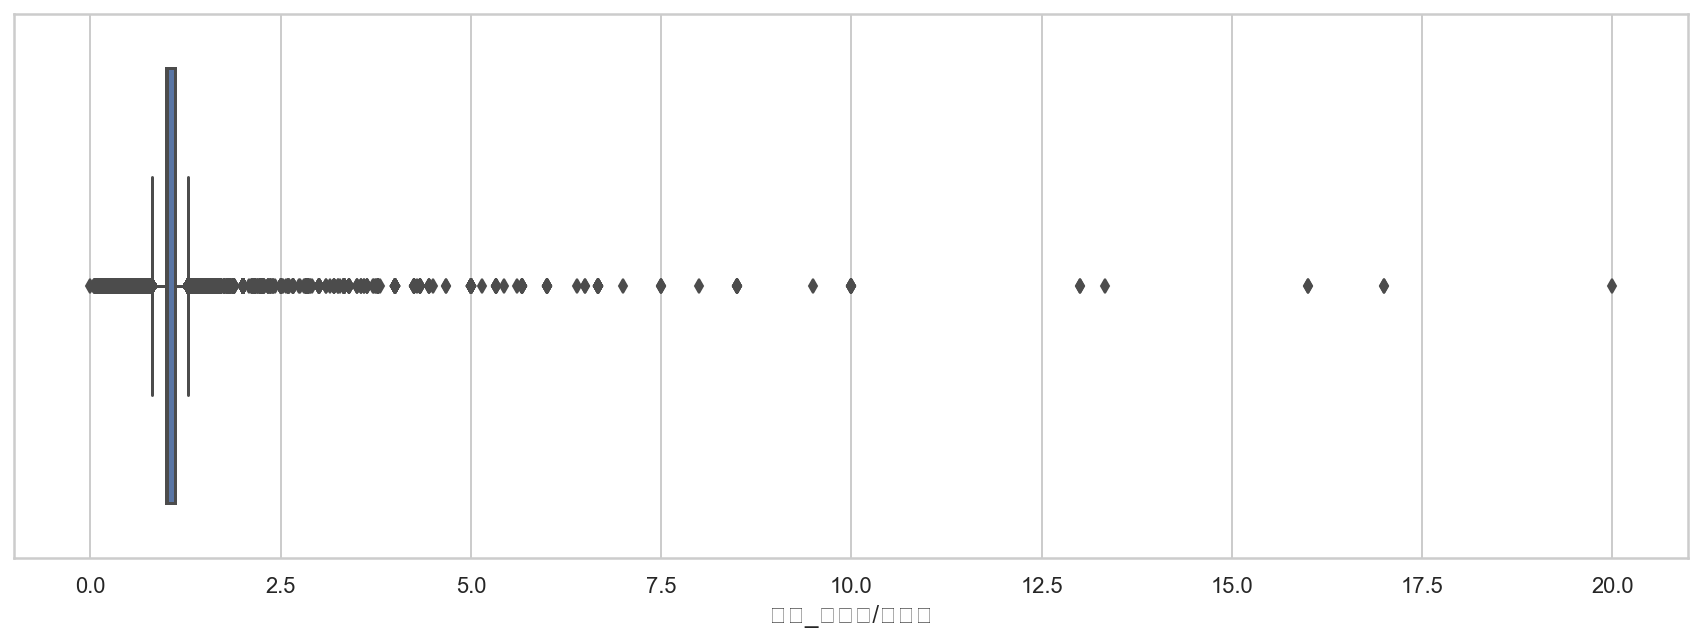

In [9]:
uf.box_plot(prev_app, "과거_승인액/요청액")

In [27]:
uf.check_feature(prev_app, "AMT_CREDIT")

====================== describe ======================
count    1.277812e+06
mean     2.448018e+05
std      3.436727e+05
min      0.000000e+00
25%      5.055300e+04
50%      1.125000e+05
75%      2.695500e+05
max      6.905160e+06
Name: AMT_CREDIT, dtype: float64
======================= unique =======================
[ 17145.   679671.   136444.5  ... 977724.   626796.   436370.22]
==================== value_counts ====================
45000.00     32177
225000.00    16968
135000.00    12983
450000.00    11421
180000.00     9653
             ...  
337315.50        1
412110.00        1
331731.00        1
338301.00        1
436370.22        1
Name: AMT_CREDIT, Length: 86803, dtype: int64
======================== isna ========================
False    1277812
Name: AMT_CREDIT, dtype: int64


## installments_payments.csv
---

In [109]:
inst_paym = pd.read_csv(uf.get_f_path()+"installments_payments.csv")

In [110]:
inst_paym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [141]:
# "AMT_PAYMENT" 실제 상환액
# 결측값은 상환하지 않았다고 판단하여 0으로 값을 대치함
# uf.check_feature(inst_paym, "AMT_PAYMENT")
inst_paym.loc[:, "AMT_PAYMENT"].fillna(0, inplace=True)

# "AMT_INSTALMENT" 할부금 총액
# "AMT_INSTALMENT" 할부금 총액 0인 행 제외
# uf.check_feature(inst_paym, "AMT_INSTALMENT")
drop_index = inst_paym.loc[inst_paym["AMT_INSTALMENT"] == 0].index
inst_paym.drop(drop_index, inplace=True)

In [152]:
# "AMT_PAYMENT" 실제 상환액 / "AMT_INSTALMENT" 할부금 총액
temp_payment = inst_paym[["SK_ID_CURR", "AMT_PAYMENT"]].groupby("SK_ID_CURR").mean()
temp_install = inst_paym[["SK_ID_CURR", "AMT_INSTALMENT"]].groupby("SK_ID_CURR").mean()
temp_merge = pd.merge(temp_payment, temp_install, left_on="SK_ID_CURR", right_on="SK_ID_CURR")
temp_merge["과거_상환액/총액"] = temp_merge["AMT_PAYMENT"] / temp_merge["AMT_INSTALMENT"]

# new_inst_paym Dataframe 만들기
new_inst_paym = temp_merge[["과거_상환액/총액"]]

# 저장
new_inst_paym.to_csv("../pre_data/new_installments_payments.csv")